### Imports

In [7]:
import os
import shutil

from zipfile import ZipFile
from random import sample

import PIL
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Model

In [11]:
from collections import defaultdict

import numpy as np

from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.preprocessing import image as process_image
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras import Model
import tensorflow as tf

class DeepModel():
    '''MobileNet deep model.'''
    def __init__(self):
        self._model = self._define_model()
        print('Loading MobileNet.')

    @staticmethod
    def _define_model(output_layer=-1):
        '''Define a pre-trained MobileNet model.
        Args:
            output_layer: the number of layer that output.
        Returns:
            Class of keras model with weights.
        '''
        base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
        output = base_model.output
        output = GlobalAveragePooling2D()(output)
        model = Model(inputs=base_model.input, outputs=output)
        return model

    @staticmethod
    def preprocess_image(path):
        '''Process an image to numpy array.
        Args:
            path: the path of the image.
        Returns:
            Numpy array of the image.
        '''
        img = process_image.load_img(path, target_size=(224, 224))
        x = process_image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        return x

    @staticmethod
    def cosine_distance(input1, input2):
        '''Calculating the distance of two inputs.
        The return values lies in [-1, 1]. `-1` denotes two features are the most unlike,
        `1` denotes they are the most similar.
        Args:
            input1, input2: two input numpy arrays.
        Returns:
            Element-wise cosine distances of two inputs.
        '''
        # return np.dot(input1, input2) / (np.linalg.norm(input1) * np.linalg.norm(input2))
        return np.dot(input1, input2.T) / np.dot(np.linalg.norm(input1, axis=1, keepdims=True), \
                                                 np.linalg.norm(input2.T, axis=0, keepdims=True))

    def extract_feature(self, img):
        '''Extract deep feature using MobileNet model.
        Args:
            generator: a predict generator inherit from `keras.utils.Sequence`.
        Returns:
            The output features of all inputs.
        '''
        features = self._model.predict(img, batch_size=1)
        return features


class ImageClassifier():
    def __init__(self, top_k=3):
        self.all_skus = defaultdict(dict) 
        self.model = DeepModel()
        self.top_k = top_k
        self.broken_images = []

    def extract_features_from_img(self, img_path):
        img = self.model.preprocess_image(img_path)
        feature = self.model.extract_feature(img)
        return feature

    def predict_class(self, img_path):
        top_k_images = self.top_k_images(img_path)
        classes = [e[2] for e in top_k_images]
        return max(classes, key = classes.count)
    
    def top_k_images(self, img_path):
        results = []
        target_features = self.extract_features_from_img(img_path)

        for img in self.all_skus: 
            features = self.all_skus[img]['feature']
            cur_distance = self.model.cosine_distance(target_features, features)
            cur_distance = cur_distance[0][0]
            results.append((img, self.all_skus[img]['path'], self.all_skus[img]['class'], cur_distance))
        
        results = sorted(results, key= lambda x: x[-1], reverse=True)[:self.top_k]
        return results

    def prepare_archive(self, dataset_path):
        self.remove_all()
        for class_id in os.listdir(dataset_path):
            cur_class_path = os.path.join(dataset_path, class_id)
            for image in os.listdir(cur_class_path):
                cur_img_path = os.path.join(cur_class_path, image)
                try:
                    feature = self.extract_features_from_img(cur_img_path)
                    self.all_skus[image]['feature'] = feature
                    self.all_skus[image]['class'] = class_id
                    self.all_skus[image]['path'] = cur_img_path
                except:
                    self.broken_images.append(cur_img_path)

    def remove_by_id(self, image_id):
        if image_id in self.all_skus:
            self.all_skus.pop(image_id)

    def remove_all(self):
        self.all_skus.clear()

2023-03-13 16:06:30.985687: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-13 16:06:31.129146: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-13 16:06:31.755257: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-13 16:06:31.755316: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

In [12]:
import typing as t
import math
import glm
import enum
import numpy as np
import cv2
import mediapipe as mp

BODY_CROPS_NAME = ['head', 'hips', 'body', 'body_and_hips', 'right_foot', 'left_foot']


class Point(t.NamedTuple):
    x: float
    y: float


class Line(t.NamedTuple):
    A: Point
    B: Point


class Rect(t.NamedTuple):
    A: Point
    B: Point
    C: Point
    D: Point


class Geometry(t.NamedTuple):
    rect_head: Rect
    rect_hips: Rect
    rect_body: Rect
    rect_body_and_hips: Rect
    rect_right_foot: Rect
    rect_left_foot: Rect


class BodyCrops(t.NamedTuple):
    head: t.Optional[np.ndarray]
    hips: t.Optional[np.ndarray]
    body: t.Optional[np.ndarray]
    body_and_hips: t.Optional[np.ndarray]
    right_foot: t.Optional[np.ndarray]
    left_foot: t.Optional[np.ndarray]


class BlazePoseBase:
    nose: int = 0
    left_eye_inner: int = 1
    left_eye: int = 2
    left_eye_outer: int = 3
    right_eye_inner: int = 4
    right_eye: int = 5
    right_eye_outer: int = 6
    left_ear: int = 7
    right_ear: int = 8
    mouth_left: int = 9
    mouth_right: int = 10
    left_shoulder: int = 11
    right_shoulder: int = 12
    left_elbow: int = 13
    right_elbow: int = 14
    left_wrist: int = 15
    right_wrist: int = 16
    left_pinky: int = 17
    right_pinky: int = 18
    left_index: int = 19
    right_index: int = 20
    left_thumb: int = 21
    right_thumb: int = 22
    left_hip: int = 23
    right_hip: int = 24
    left_knee: int = 25
    right_knee: int = 26
    left_ankle: int = 27
    right_ankle: int = 28
    left_heel: int = 29
    right_heel: int = 30
    left_foot_index: int = 31
    right_foot_index: int = 32
    total_count: int = 33


class BlazePose(enum.Enum):
    nose: int = 0
    left_eye_inner: int = 1
    left_eye: int = 2
    left_eye_outer: int = 3
    right_eye_inner: int = 4
    right_eye: int = 5
    right_eye_outer: int = 6
    left_ear: int = 7
    right_ear: int = 8
    mouth_left: int = 9
    mouth_right: int = 10
    left_shoulder: int = 11
    right_shoulder: int = 12
    left_elbow: int = 13
    right_elbow: int = 14
    left_wrist: int = 15
    right_wrist: int = 16
    left_pinky: int = 17
    right_pinky: int = 18
    left_index: int = 19
    right_index: int = 20
    left_thumb: int = 21
    right_thumb: int = 22
    left_hip: int = 23
    right_hip: int = 24
    left_knee: int = 25
    right_knee: int = 26
    left_ankle: int = 27
    right_ankle: int = 28
    left_heel: int = 29
    right_heel: int = 30
    left_foot_index: int = 31
    right_foot_index: int = 32
    total_count: int = 33


def spoint(point: t.Any) -> Point:
    return Point(point.x, point.y)


def get_middle_point(l: t.Optional[Line] = None, p1: t.Optional[Point] = None, p2: t.Optional[Point] = None) -> Point:
    if p1 is None and p2 is None:
        return Point(min(l.A.x, l.B.x) + abs(l.A.x - l.B.x) / 2, min(l.A.y, l.B.y) + abs(l.A.y - l.B.y) / 2)
    else:
        l = Line(Point(p1.x, p1.y), Point(p2.x, p2.y))
        return Point(min(l.A.x, l.B.x) + abs(l.A.x - l.B.x) / 2, min(l.A.y, l.B.y) + abs(l.A.y - l.B.y) / 2)


def get_line_length(l: Line) -> float:
    return math.sqrt((l.A.x - l.B.x) * (l.A.x - l.B.x) + (l.A.y - l.B.y) * (l.A.y - l.B.y))


def get_line_extension(l: Line, extension: float) -> Point:
    length: float = get_line_length(l)
    try:
        dx_add: float = (l.A.x - l.B.x) * extension / length
        dy_add: float = (l.A.y - l.B.y) * extension / length
    except ZeroDivisionError:
        dx_add, dy_add = 0, 0
    return Point(l.A.x + dx_add, l.A.y + dy_add)


def get_rect_extension(r: Rect, extension: float):
    A = get_line_extension(Line(r.A, r.D), extension / 2)
    B = get_line_extension(Line(r.B, r.C), extension / 2)
    A = get_line_extension(Line(A, B), extension / 2)
    B = get_line_extension(Line(B, A), extension / 2)
    C = get_line_extension(Line(r.C, r.B), extension / 2)
    D = get_line_extension(Line(r.D, r.A), extension / 2)
    C = get_line_extension(Line(C, D), extension / 2)
    D = get_line_extension(Line(D, C), extension / 2)
    extended: Rect = Rect(A, B, C, D)

    return extended


def get_distance_from_point_to_line(p: Point, l: Line) -> float:
    normal_length = get_line_length(l)
    try:
        distance = ((p.x - l.A.x) * (l.B.y - l.A.y) - (p.y - l.A.y) * (l.B.x - l.A.x)) / normal_length
    except ZeroDivisionError:
        return 0
    return distance


def get_head_rect(r_eye: Point, l_eye: Point, r_mouth: Point, l_mouth: Point, nose: Point) -> Rect:
    HTNBM_Rate = 1.8
    NBMHB_Rate = 0.8

    eye_c: Point = get_middle_point(p1=r_eye, p2=l_eye)
    mouth_c: Point = get_middle_point(p1=r_mouth, p2=l_mouth)

    face_base_len = get_line_length(Line(eye_c, mouth_c))

    face_top: Point = get_line_extension(Line(eye_c, mouth_c), HTNBM_Rate * face_base_len)
    face_bot: Point = get_line_extension(Line(mouth_c, eye_c), NBMHB_Rate * face_base_len)

    nose_deviation = get_distance_from_point_to_line(nose, Line(face_bot, face_top))

    move_coef: float = math.fabs(nose_deviation) / get_line_length(Line(eye_c, mouth_c))

    dx: float = face_bot.x - face_top.x
    dy: float = face_bot.y - face_top.y

    topLeftX: float = face_top.x - dy * (1 - move_coef) / 2 if nose_deviation >= 0 else face_top.x - dy * (1 + move_coef) / 2
    topLeftY: float = face_top.y + dx * (1 - move_coef) / 2 if nose_deviation >= 0 else face_top.y + dx * (1 + move_coef) / 2

    topRigxtX: float = face_top.x + dy * (1 + move_coef) / 2 if nose_deviation >= 0 else face_top.x + dy * (1 - move_coef) / 2
    topRightY: float = face_top.y - dx * (1 + move_coef) / 2 if nose_deviation >= 0 else face_top.y - dx * (1 - move_coef) / 2

    botRigxtX: float = face_bot.x + dy * (1 + move_coef) / 2 if nose_deviation >= 0 else face_bot.x + dy * (1 - move_coef) / 2
    botRightY: float = face_bot.y - dx * (1 + move_coef) / 2 if nose_deviation >= 0 else face_bot.y - dx * (1 - move_coef) / 2

    botLeftX = face_bot.x - dy * (1 - move_coef) / 2 if nose_deviation >= 0 else face_bot.x - dy * (1 + move_coef) / 2
    botLeftY = face_bot.y + dx * (1 - move_coef) / 2 if nose_deviation >= 0 else face_bot.y + dx * (1 + move_coef) / 2

    return Rect(Point(topLeftX, topLeftY), Point(topRigxtX, topRightY), Point(botRigxtX, botRightY), Point(botLeftX, botLeftY))



def get_leg_rect(hip: Point, knee: Point, ankle: Point, heel: Point, big_finger: Point):
        FKA_Rate = 0.4
        width_1 = get_line_length(Line(hip, knee)) * FKA_Rate
        width_2 = get_line_length(Line(knee, ankle)) * FKA_Rate
        width_3 = get_line_length(Line(heel, big_finger))

        width = max(max(width_1, width_2), width_3)

        knee_dist = get_distance_from_point_to_line(knee, Line(hip, heel))
        leg_base_length = get_line_length(Line(hip, heel))

        dx = knee_dist * (hip.y - heel.y) / leg_base_length
        dy = knee_dist * (hip.x - heel.x) / leg_base_length

        return get_rect_extension(Rect(Point(hip.x + dx, hip.y - dy), hip, ankle, Point(ankle.x + dx, ankle.y - dy)), width * 1.5)


def get_hand_rect(shoulder: Point, elbow: Point, wrist: Point, t_finger: Point, i_finger: Point, l_finger: Point):
        SEW_Rate = 0.3
        width_1 = get_line_length(Line(shoulder, elbow)) * SEW_Rate
        width_2 = get_line_length(Line(elbow, wrist)) * SEW_Rate
        width_3 = get_line_length(Line(wrist, t_finger))
        width_4 = get_line_length(Line(wrist, i_finger))
        width_5 = get_line_length(Line(wrist, l_finger))

        w = (width_1, width_2, width_3, width_4, width_5)
        width = max(w)

        elbow_dist = get_distance_from_point_to_line(elbow, Line(shoulder, wrist))

        hand_base_length = get_line_length(Line(shoulder, wrist ))

        dx = elbow_dist * (wrist.y - shoulder.y) / hand_base_length
        dy = elbow_dist * (wrist.x - shoulder.x) / hand_base_length

        return get_rect_extension(Rect(Point(shoulder.x + dx, shoulder.y - dy), shoulder, wrist, Point(wrist.x + dx, wrist.y - dy)), width * 1.5)


def getTorsoRect(r_startpoint: Point, l_startpoint: Point, r_hip: Point, l_hip: Point):
        shoulder_center: Point = get_middle_point(p1=r_startpoint, p2=l_startpoint)
        hip_center: Point = get_middle_point(p1=r_hip, p2=l_hip)

        add_to_top = math.fabs((r_startpoint.y - shoulder_center.y) / (r_startpoint.x - shoulder_center.x) * get_line_length(Line(r_startpoint, l_startpoint)) / 2)
        add_to_bot = math.fabs((r_hip.y - hip_center.y) / (r_hip.x - hip_center.x) * get_line_length(Line(r_hip, l_hip)) / 2)

        base_top: Point = get_line_extension(Line(shoulder_center , hip_center), add_to_top)
        base_bot: Point = get_line_extension(Line(hip_center , shoulder_center), add_to_bot)

        torso_base_length: float = get_line_length(Line(base_top, base_bot))

        torso_width: float = max(get_line_length(Line(r_startpoint, l_startpoint)), get_line_length(Line(r_hip, l_hip)))

        dx: float = torso_width * (base_top.y - base_bot.y) / (2 * torso_base_length)
        dy: float = torso_width * (base_top.x - base_bot.x) / (2 * torso_base_length)

        return get_rect_extension(Rect(Point(base_top.x + dx, base_top.y - dy), Point(base_top.x - dx, base_top.y + dy),
                                    Point(base_bot.x - dx, base_bot.y + dy), Point(base_bot.x + dx, base_bot.y - dy )), torso_base_length / 4)


def getHipsRect(r_hip: Point, l_hip: Point, r_endpoint: Point, l_endpoint: Point):
        hip_center = get_middle_point(p1=r_hip, p2=l_hip)
        knee_center = get_middle_point(p1=r_endpoint, p2=l_endpoint)

        add_to_top = math.fabs((r_hip.y - hip_center.y) / (r_hip.x - hip_center.x) * get_line_length(Line( r_hip, l_hip)) / 2)
        add_to_bot = math.fabs((r_endpoint.y - knee_center.y) / (r_endpoint.x - knee_center.x) * get_line_length(Line(r_endpoint, l_endpoint)) / 2)

        base_top: Point = get_line_extension(Line(hip_center , knee_center), add_to_top)
        base_bot: Point = get_line_extension(Line(knee_center , hip_center), add_to_bot)

        hip_base_length: float = get_line_length(Line(base_top, base_bot))

        hip_width: float = max(get_line_length(Line(r_hip, l_hip)), get_line_length(Line(r_endpoint, l_endpoint)))

        dx: float = hip_width * (base_top.y - base_bot.y) / (2 * hip_base_length)
        dy: float = hip_width * (base_top.x - base_bot.x) / (2 * hip_base_length)

        return get_rect_extension(Rect(Point(base_top.x + dx, base_top.y - dy), Point(base_top.x - dx, base_top.y + dy),
                                    Point(base_bot.x - dx, base_bot.y + dy), Point(base_bot.x + dx, base_bot.y - dy )), hip_base_length / 3)


def getTorsoAndHipsRect(r_shoulder: Point, l_shoulder: Point, r_hip: Point, l_hip: Point, r_knee: Point, l_knee: Point):
        shoulder_center: Point = get_middle_point(p1=r_shoulder, p2=l_shoulder)
        knee_center: Point = get_middle_point(p1=r_knee, p2=l_knee)

        add_to_top: float = math.fabs((r_shoulder.y - shoulder_center.y) / (r_shoulder.x - shoulder_center.x) * get_line_length(Line(r_shoulder, l_shoulder)) / 2)
        add_to_bot: float = math.fabs((r_knee.y - knee_center.y) / (r_knee.x - knee_center.x) * get_line_length(Line(r_knee, l_knee)) / 2)

        base_top: Point = get_line_extension(Line(shoulder_center , knee_center), add_to_top)
        base_bot: Point = get_line_extension(Line(knee_center , shoulder_center), add_to_bot)

        points = [r_shoulder, l_shoulder, r_hip, l_hip, r_knee, l_knee]
        distances = []
        for p in points:
            distances.append(get_distance_from_point_to_line(p, Line(base_top, base_bot)))

        max_pos_dev: float = max(distances)
        max_neg_dev: float = min(distances)

        base_length: float = get_line_length(Line(base_top, base_bot))

        dx_pos: float = math.fabs(max_pos_dev * (base_top.y - base_bot.y) / base_length)
        dy_pos: float = max_pos_dev * (base_top.x - base_bot.x) / base_length

        dx_neg: float = math.fabs(max_neg_dev * (base_top.y - base_bot.y) / base_length)
        dy_neg: float = max_neg_dev * (base_top.x - base_bot.x) / base_length

        return get_rect_extension(Rect(Point(base_top.x - dx_neg, base_top.y + dy_neg), Point(base_top.x + dx_pos, base_top.y + dy_pos),
            Point(base_bot.x + dx_pos, base_bot.y + dy_pos), Point(base_bot.x - dx_neg, base_bot.y + dy_neg)),
            (math.fabs(max_pos_dev) + math.fabs(max_neg_dev)) / 3)

def getFootRect(ankle: Point, heel: Point, big_finger: Point) -> Rect:
        af: float = get_line_length(Line(ankle, big_finger))
        hf: float = get_line_length(Line(heel, big_finger))
        ad: float = get_distance_from_point_to_line(ankle, Line(heel, big_finger))

        foot_base_length: float = get_line_length(Line(heel, big_finger))

        foot_width: float = foot_base_length if foot_base_length > math.fabs(ad) else math.fabs(ad)

        try:
            dx: float = ad * (heel.y - big_finger.y) / foot_base_length
            dy: float = ad * (heel.x - big_finger.x) / foot_base_length
        except ZeroDivisionError:
            dx, dy = 0, 0

        if af < hf:
            return get_rect_extension(Rect(Point( heel.x - dx, heel.y + dy), heel, big_finger, Point(big_finger.x - dx, big_finger.y + dy)), foot_width)
        else:
            return get_rect_extension(Rect(Point(ankle.x + dx, ankle.y - dy), ankle, Point(big_finger.x - dx, big_finger.y + dy), big_finger), foot_width)


def getWristRect(wrist: Point, t_finger: Point, i_finger: Point, l_finger: Point) -> Rect:
        width_1: float = get_line_length(Line(wrist, t_finger))
        width_2: float = get_line_length(Line(wrist, i_finger))
        width_3: float = get_line_length(Line(wrist, l_finger))

        w = [width_1, width_2, width_3]
        width: float = max(w)

        wrist_base_line = Line(wrist, get_middle_point(p1=i_finger, p2=l_finger))

        dx: float = (wrist_base_line.A.y - wrist_base_line.B.y) / 2
        dy: float = (wrist_base_line.A.x - wrist_base_line.B.x) / 2

        C: Point = get_middle_point(wrist_base_line)
        D: Point = C
        C = Point(C.x + dx, C.y - dy)
        D = Point(D.x - dx, D.y + dy)

        r: Rect = Rect(wrist_base_line.A , C, wrist_base_line.B, D)

        wrist_base_rect: Rect = Rect(get_middle_point(p1=r.A, p2=r.B) , get_middle_point(p1=r.B, p2=r.C), get_middle_point(p1=r.C, p2=r.D), get_middle_point(p1=r.D, p2=r.A))

        return get_rect_extension(wrist_base_rect, width*2)


def blaze_all(landmarks: t.List[glm.vec3]) -> dict:
    result: dict = {}

    result['nose'] = {'x': spoint(landmarks[BlazePoseBase.nose]).x, 'y': spoint(landmarks[BlazePoseBase.nose]).y, 'p': 0.9}
    result['left_eye'] = {'x': spoint(landmarks[BlazePoseBase.left_eye]).x, 'y': spoint(landmarks[BlazePoseBase.left_eye]).y, 'p': 0.9}
    result['right_eye'] = {'x': spoint(landmarks[BlazePoseBase.right_eye]).x, 'y': spoint(landmarks[BlazePoseBase.right_eye]).y, 'p': 0.9}
    result['left_ear'] = {'x': spoint(landmarks[BlazePoseBase.left_ear]).x, 'y': spoint(landmarks[BlazePoseBase.left_ear]).y, 'p': 0.9}
    result['right_ear'] = {'x': spoint(landmarks[BlazePoseBase.right_ear]).x, 'y': spoint(landmarks[BlazePoseBase.right_ear]).y, 'p': 0.9}
    result['left_shoulder'] = {'x': spoint(landmarks[BlazePoseBase.left_shoulder]).x, 'y': spoint(landmarks[BlazePoseBase.left_shoulder]).y, 'p': 0.9}
    result['right_shoulder'] = {'x': spoint(landmarks[BlazePoseBase.right_shoulder]).x, 'y': spoint(landmarks[BlazePoseBase.right_shoulder]).y, 'p': 0.9}
    result['left_elbow'] = {'x': spoint(landmarks[BlazePoseBase.left_elbow]).x, 'y': spoint(landmarks[BlazePoseBase.left_elbow]).y, 'p': 0.9}
    result['right_elbow'] = {'x': spoint(landmarks[BlazePoseBase.right_ear]).x, 'y': spoint(landmarks[BlazePoseBase.right_elbow]).y, 'p': 0.9}
    result['left_wrist'] = {'x': spoint(landmarks[BlazePoseBase.left_wrist]).x, 'y': spoint(landmarks[BlazePoseBase.left_wrist]).y, 'p': 0.9}
    result['right_wrist'] = {'x': spoint(landmarks[BlazePoseBase.right_wrist]).x, 'y': spoint(landmarks[BlazePoseBase.right_wrist]).y, 'p': 0.9}
    result['left_hip'] = {'x': spoint(landmarks[BlazePoseBase.left_hip]).x, 'y': spoint(landmarks[BlazePoseBase.left_hip]).y, 'p': 0.9}
    result['right_hip'] = {'x': spoint(landmarks[BlazePoseBase.right_hip]).x, 'y': spoint(landmarks[BlazePoseBase.right_hip]).y, 'p': 0.9}
    result['left_knee'] = {'x': spoint(landmarks[BlazePoseBase.left_knee]).x, 'y': spoint(landmarks[BlazePoseBase.left_knee]).y, 'p': 0.9}
    result['right_knee'] = {'x': spoint(landmarks[BlazePoseBase.right_knee]).x, 'y': spoint(landmarks[BlazePoseBase.right_knee]).y, 'p': 0.9}
    result['left_ankle'] = {'x': spoint(landmarks[BlazePoseBase.left_ankle]).x, 'y': spoint(landmarks[BlazePoseBase.left_ankle]).y, 'p': 0.9}
    result['right_ankle'] = {'x': spoint(landmarks[BlazePoseBase.right_ankle]).x, 'y': spoint(landmarks[BlazePoseBase.right_ankle]).y, 'p': 0.9}
    result['neck'] = {'x': spoint(landmarks[BlazePoseBase.right_eye]).x + spoint(landmarks[BlazePoseBase.right_eye_outer]).x / 2,
                      'y': spoint(landmarks[BlazePoseBase.right_eye]).y + spoint(landmarks[BlazePoseBase.right_eye_outer]).y / 2, 'p': 0.9}

    return result


def blaze_head(landmarks: t.List[glm.vec3]) -> Rect:
    r_eye = spoint(landmarks[BlazePoseBase.right_eye])
    l_eye = spoint(landmarks[BlazePoseBase.left_eye])
    r_mouth = spoint(landmarks[BlazePoseBase.mouth_right])
    l_mouth = spoint(landmarks[BlazePoseBase.mouth_left])
    nose = spoint(landmarks[BlazePoseBase.nose])

    return get_head_rect(r_eye, l_eye, r_mouth, l_mouth, nose)


def blaze_right_hand(landmarks: t.List[glm.vec3]) -> Rect:
    shoulder = spoint(landmarks[BlazePoseBase.right_shoulder])
    elbow = spoint(landmarks[BlazePoseBase.right_elbow])
    wrist = spoint(landmarks[BlazePoseBase.right_wrist])
    t_finger = spoint(landmarks[BlazePoseBase.right_pinky])
    i_finger = spoint(landmarks[BlazePoseBase.right_index])
    l_finger = spoint(landmarks[BlazePoseBase.right_thumb])

    return get_hand_rect(shoulder, elbow, wrist, t_finger, i_finger, l_finger)


def blaze_left_hand(landmarks: t.List[glm.vec3]) -> Rect:
    shoulder = spoint(landmarks[BlazePoseBase.left_shoulder])
    elbow = spoint(landmarks[BlazePoseBase.left_elbow])
    wrist = spoint(landmarks[BlazePoseBase.left_wrist])
    t_finger = spoint(landmarks[BlazePoseBase.left_pinky])
    i_finger = spoint(landmarks[BlazePoseBase.left_index])
    l_finger = spoint(landmarks[BlazePoseBase.left_thumb])

    return get_hand_rect(shoulder, elbow, wrist, t_finger, i_finger, l_finger)


def blaze_right_leg(landmarks: t.List[glm.vec3]):
    hip = spoint(landmarks[BlazePoseBase.right_hip])
    knee = spoint(landmarks[BlazePoseBase.right_knee])
    ankle = spoint(landmarks[BlazePoseBase.right_ankle])
    heel = spoint(landmarks[BlazePoseBase.right_heel])
    big_finger = spoint(landmarks[BlazePoseBase.right_foot_index])

    return get_leg_rect(hip, knee, ankle, heel, big_finger)


def blaze_left_leg(landmarks: t.List[glm.vec3]):
    hip = spoint(landmarks[BlazePoseBase.left_hip])
    knee = spoint(landmarks[BlazePoseBase.left_knee])
    ankle = spoint(landmarks[BlazePoseBase.left_ankle])
    heel = spoint(landmarks[BlazePoseBase.left_heel])
    big_finger = spoint(landmarks[BlazePoseBase.left_foot_index])

    return get_leg_rect(hip, knee, ankle, heel, big_finger)


def blaze_torso(landmarks: t.List[glm.vec3]):
    r_shoulder = spoint(landmarks[BlazePoseBase.right_shoulder])
    l_shoulder = spoint(landmarks[BlazePoseBase.left_shoulder])
    r_hip = spoint(landmarks[BlazePoseBase.right_hip])
    l_hip = spoint(landmarks[BlazePoseBase.left_hip])

    r_wrist = spoint(landmarks[BlazePoseBase.right_wrist])
    l_wrist = spoint(landmarks[BlazePoseBase.left_wrist])

    if l_wrist.y < l_shoulder.y:
        l_startpoint = l_wrist
    else:
        l_startpoint = l_shoulder

    if r_wrist.y < r_shoulder.y:
        r_startpoint = r_wrist
    else:
        r_startpoint = r_shoulder

    return getTorsoRect(r_startpoint, l_startpoint, r_hip, l_hip)


def blaze_hips(landmarks: t.List[glm.vec3]):
    r_hip = spoint(landmarks[BlazePoseBase.right_hip])
    l_hip = spoint(landmarks[BlazePoseBase.left_hip])
    r_knee = spoint(landmarks[BlazePoseBase.right_knee])
    l_knee = spoint(landmarks[BlazePoseBase.left_knee])

    l_heel = spoint(landmarks[BlazePoseBase.left_heel])
    r_heel = spoint(landmarks[BlazePoseBase.right_heel])

    return getHipsRect(r_hip, l_hip, r_heel, l_heel)


def blaze_torso_and_hips(landmarks: t.List[glm.vec3]):
    r_shoulder = spoint(landmarks[BlazePoseBase.right_shoulder])
    l_shoulder = spoint(landmarks[BlazePoseBase.left_shoulder])
    r_hip = spoint(landmarks[BlazePoseBase.right_hip])
    l_hip = spoint(landmarks[BlazePoseBase.left_hip])
    r_knee = spoint(landmarks[BlazePoseBase.right_knee])
    l_knee = spoint(landmarks[BlazePoseBase.left_knee])

    return getTorsoAndHipsRect(r_shoulder, l_shoulder, r_hip, l_hip, r_knee, l_knee)


def blaze_left_foot(landmarks: t.List[glm.vec3]):
    ankle = spoint(landmarks[BlazePoseBase.left_ankle])
    heel = spoint(landmarks[BlazePoseBase.left_heel])
    big_finger = spoint(landmarks[BlazePoseBase.left_foot_index])
    return getFootRect(ankle, heel, big_finger)


def blaze_right_foot(landmarks: t.List[glm.vec3]):
    ankle = spoint(landmarks[BlazePoseBase.right_ankle])
    heel = spoint(landmarks[BlazePoseBase.right_heel])
    big_finger = spoint(landmarks[BlazePoseBase.right_foot_index])
    return getFootRect(ankle, heel, big_finger)


def blaze_left_wrist(landmarks: t.List[glm.vec3]):
    wrist = spoint(landmarks[BlazePoseBase.left_wrist])
    t_finger = spoint(landmarks[BlazePoseBase.left_pinky])
    i_finger = spoint(landmarks[BlazePoseBase.left_index])
    l_finger = spoint(landmarks[BlazePoseBase.left_thumb])
    return getWristRect(wrist, t_finger, i_finger, l_finger)


def blaze_right_wrist(landmarks: t.List[glm.vec3]):
    wrist = spoint(landmarks[BlazePoseBase.right_wrist])
    t_finger = spoint(landmarks[BlazePoseBase.right_pinky])
    i_finger = spoint(landmarks[BlazePoseBase.right_index])
    l_finger = spoint(landmarks[BlazePoseBase.right_thumb])
    return getWristRect(wrist, t_finger, i_finger, l_finger)


def denormalized_point(image: np.ndarray, point: Point) -> Point:
    return Point(point.x * image.shape[1], point.y * image.shape[0])


def denormalized_rect(image: np.ndarray, rect: Rect) -> t.Tuple:
    a = denormalized_point(image, rect.A)
    b = denormalized_point(image, rect.B)
    c = denormalized_point(image, rect.C)
    d = denormalized_point(image, rect.D)

    return cv2.minAreaRect(np.array([list(a), list(b), list(c), list(d)], dtype=np.float32))


def normalized_rect(rect: Rect):
    a = list(Point(rect.A.x, rect.A.y))
    b = list(Point(rect.B.x, rect.B.y))
    c = list(Point(rect.C.x, rect.C.y))
    d = list(Point(rect.D.x, rect.D.y))

    return cv2.minAreaRect(np.array([a, b, c, d], dtype=np.float32))


def annotate_point(image: np.ndarray, point: Point, color) -> np.ndarray:
    return cv2.circle(image, denormalized_point(image, point), 2, color, 1)


def annotate_line(image: np.ndarray, p0: Point, p1: Point, color) -> np.ndarray:
    return cv2.line(image, denormalized_point(image, p0), denormalized_point(image, p1), color, 2, 1)


def annotate_rect(image: np.ndarray, rect: Rect, color) -> np.ndarray:
    image = annotate_point(image, rect.A, color)
    image = annotate_point(image, rect.B, color)
    image = annotate_point(image, rect.C, color)
    image = annotate_point(image, rect.D, color)

    image = annotate_line(image, rect.A, rect.B, color)
    image = annotate_line(image, rect.B, rect.C, color)
    image = annotate_line(image, rect.C, rect.D, color)
    image = annotate_line(image, rect.D, rect.A, color)

    return image


def simple_crop_rect(img: np.ndarray, rect: t.Tuple, use_rotation=True) -> np.ndarray:
    # rotate img
    box = cv2.boxPoints(rect)
    box = np.int0(box)

    (height, width, _) = img.shape

    W = rect[1][0]
    H = rect[1][1]

    Xs = [i[0] for i in box]
    Ys = [i[1] for i in box]
    x1 = min(Xs)
    x2 = max(Xs)
    y1 = min(Ys)
    y2 = max(Ys)

    left, top, right, bottom = 0, 0, 0, 0
    if x1 < 0:
        left = abs(x1)
    elif x1 > width:
        left = width - 1
    if y1 < 0:
        top = abs(y1)
    elif y1 > height:
        top = height - 1
    if x2 < 0:
        right = abs(x2)
    elif x2 > width:
        right = width - 1
    if y2 < 0:
        bottom = abs(y2)
    elif y2 > height:
        bottom = height - 1

    img = cv2.copyMakeBorder(img, top=top, bottom=bottom, right=right, left=left, borderType=cv2.BORDER_CONSTANT)

    angle = rect[2]
    if angle < -45:
        angle += 90

    # Center of rectangle in source image
    center = ((x1 + x2) / 2, (y1 + y2) / 2)
    # Size of the upright rectangle bounding the rotated rectangle
    size = (x2 - x1, y2 - y1)
    M = cv2.getRotationMatrix2D((size[0] / 2, size[1] / 2), angle, 1.0)
    # Cropped upright rectangle
    cropped = cv2.getRectSubPix(img, size, center)
    if use_rotation:
        cropped = cv2.warpAffine(cropped, M, size, borderMode=cv2.BORDER_CONSTANT)
    croppedW = H if H > W else W
    croppedH = H if H < W else W
    # Final cropped & rotated rectangle
    # croppedRotated = cv2.getRectSubPix(cropped, (int(croppedW), int(croppedH)), (size[0] / 2, size[1] / 2))
    return cropped


def fill_images(source: np.ndarray, resize_to_square: float, geometry: Geometry):
    head = simple_crop_rect(source, denormalized_rect(source, geometry.rect_head), use_rotation=False)
    hips = simple_crop_rect(source, denormalized_rect(source, geometry.rect_hips), use_rotation=False)
    body = simple_crop_rect(source, denormalized_rect(source, geometry.rect_body), use_rotation=False)
    body_and_hips = simple_crop_rect(source, denormalized_rect(source, geometry.rect_body_and_hips), use_rotation=False)
    right_foot = simple_crop_rect(source, denormalized_rect(source, geometry.rect_right_foot), use_rotation=False)
    left_foot = simple_crop_rect(source, denormalized_rect(source, geometry.rect_left_foot), use_rotation=False)

    return BodyCrops(head=head, hips=hips, body=body, body_and_hips=body_and_hips, right_foot=right_foot,
                     left_foot=left_foot)


def get_person(geometry: Geometry):
    body = geometry.rect_body
    head = geometry.rect_head
    l_foot = geometry.rect_left_foot
    r_foot = geometry.rect_right_foot
    top = head.A.y
    left = body.A.x
    right = body.B.x
    bottom = max(l_foot.D.y, r_foot.D.y)
    return left, top, right, bottom


def get_body_part(rect: Rect):
    left = min(rect.A.x, rect.B.x)
    right = max(rect.A.x, rect.B.x)
    top = min(rect.A.y, rect.D.y)
    bottom = max(rect.A.y, rect.D.y)
    return left, top, right, bottom


def annotate_detections(image: np.ndarray, landmarks: t.List[glm.vec3], landmarksColor):
    if len(landmarks) == BlazePoseBase.total_count:
        for point in landmarks:
            image = cv2.circle(image, denormalized_point(image, spoint(point)), 2, landmarksColor, 1)

        image = annotate_rect(image, blaze_head(landmarks), (70, 150, 200))
        image = annotate_rect(image, blaze_left_wrist(landmarks), (200, 70, 150))
        image = annotate_rect(image, blaze_right_wrist(landmarks), (200, 70, 150))
    return image


def init_geometry(landmarks: t.List[glm.vec3]) -> Geometry:
    rect_head = blaze_head(landmarks)
    rect_hips = blaze_hips(landmarks)
    rect_body = blaze_torso(landmarks)
    rect_body_and_hips = blaze_torso_and_hips(landmarks)
    rect_right_foot = blaze_right_foot(landmarks)
    rect_left_foot = blaze_left_foot(landmarks)

    return Geometry(rect_head, rect_hips, rect_body, rect_body_and_hips, rect_right_foot, rect_left_foot)


def crop_image(source_image: np.ndarray, take_crops: bool = False, is_take_coords: bool = False) -> t.Union[dict, BodyCrops, tuple]:
    mp_pose = mp.solutions.pose
    landmarks: t.List[glm.vec3] = []

    with mp_pose.Pose(
            static_image_mode=True,
            model_complexity=2,
            enable_segmentation=True,
            min_detection_confidence=0.5) as pose:
        image_height, image_width, _ = source_image.shape
        # Convert the BGR image to RGB before processing.
        results = pose.process(cv2.cvtColor(source_image, cv2.COLOR_BGR2RGB))

        if not results.pose_landmarks:
            result_dict = {}

            result_dict['nose'] = {'x': 0, 'y': 0, 'p': 0.9}
            result_dict['left_eye'] = {'x': 0, 'y': 0, 'p': 0.9}
            result_dict['right_eye'] = {'x': 0, 'y': 0, 'p': 0.9}
            result_dict['left_ear'] = {'x': 0, 'y': 0, 'p': 0.9}
            result_dict['right_ear'] = {'x': 0, 'y': 0, 'p': 0.9}
            result_dict['left_shoulder'] = {'x': 0, 'y': 0, 'p': 0.9}
            result_dict['right_shoulder'] = {'x': 0, 'y': 0, 'p': 0.9}
            result_dict['left_elbow'] = {'x': 0, 'y': 0, 'p': 0.9}
            result_dict['right_elbow'] = {'x': 0, 'y': 0, 'p': 0.9}
            result_dict['left_wrist'] = {'x': 0, 'y': 0, 'p': 0.9}
            result_dict['right_wrist'] = {'x': 0, 'y': 0, 'p': 0.9}
            result_dict['left_hip'] = {'x': 0, 'y': 0, 'p': 0.9}
            result_dict['right_hip'] = {'x': 0, 'y': 0, 'p': 0.9}
            result_dict['left_knee'] = {'x': 0, 'y': 0, 'p': 0.9}
            result_dict['right_knee'] = {'x': 0, 'y': 0, 'p': 0.9}
            result_dict['left_ankle'] = {'x': 0, 'y': 0, 'p': 0.9}
            result_dict['right_ankle'] = {'x': 0, 'y': 0, 'p': 0.9}
            result_dict['neck'] = {'x': 0, 'y': 0, 'p': 0.9}
            return result_dict
        # print(
        #     f'Nose coordinates: ('
        #     f'{results.pose_landmarks.landmark[mp_pose.PoseLandmark.NOSE].x * image_width}, '
        #     f'{results.pose_landmarks.landmark[mp_pose.PoseLandmark.NOSE].y * image_height})'
        # )
        for keypoint in results.pose_landmarks.landmark:
            landmarks.append(glm.vec3(keypoint.x, keypoint.y, keypoint.z))

        if take_crops:
            geometry = init_geometry(landmarks)
            images = fill_images(source_image, 0, geometry)
            return images
        elif is_take_coords:
            geometry = init_geometry(landmarks)

            return get_person(geometry), get_body_part(geometry.rect_body), get_body_part(geometry.rect_body_and_hips),\
                   get_body_part(geometry.rect_hips), get_body_part(geometry.rect_left_foot), get_body_part(geometry.rect_right_foot),


        else:
            return blaze_all(landmarks)

In [13]:
def creat_crop_images(path):
    image = cv2.imread(path)
    crops = crop_image(image, take_crops=True)
    count: int = 0
    for crop in crops:
        cv2.imwrite(f"{count}.jpg", crop)
        count += 1

### Functions

In [15]:
def accuracy(test_path):
    acc_dict = {}
    acc_total = []
    broken_test_images = []

    class_names = os.listdir(test_path)
    for class_name in class_names:
        acc_class = []
        cur_path = os.path.join(test_path, class_name)
        for image in os.listdir(cur_path):
            cur_img = os.path.join(cur_path, image)
            try:
                result_class = classifier.predict_class(cur_img)
                acc_class.append(result_class == class_name)
                acc_total.append(result_class == class_name)
            except:
                broken_test_images.append(cur_img)
        acc_dict[class_name] = np.mean(acc_class)
    acc_total = np.mean(acc_total)
    return acc_total, acc_dict

In [16]:
def plot_one(path, class_name=None):
    if class_name is None:
        class_name = path.split('/')[-2]
    plt.figure(figsize=(6, 6))
    image = mpimg.imread(path)
    plt.axis("off")
    plt.imshow(image)
    plt.title(class_name)

In [17]:
def image_top_k(path, class_name=None):
    if class_name is None:
        class_name = path.split('/')[-2]
    results = classifier.top_k_images(path)
    plt.figure(figsize=(18, 6))
    for i in range(4):
        image = mpimg.imread(results[i][1])
        name = results[i][2]
        dist = results[i][3]
        plt.subplot(2, 4, i+1)
        plt.axis("off")
        plt.imshow(image)
        if class_name == name:
            plt.title(f'{name}\n{dist}')
        else:
            plt.title(f'{name}\n{dist}', color='red')

        image = mpimg.imread(results[i+4][1])
        name = results[i+4][2]
        dist = results[i+4][3]
        plt.subplot(2, 4, i+5)
        plt.axis("off")
        plt.imshow(image)
        plt.title(f'{name}\n{dist}')
        if class_name == name:
            plt.title(f'{name}\n{dist}')
        else:
            plt.title(f'{name}\n{dist}', color='red')
    plt.show();

In [41]:
def plot_part(part):
    i = BODY_CROPS_NAME.index(part)
    results = classifier.top_k_images(f'./{i}.jpg')[:3]
    image = mpimg.imread(f'./{i}.jpg')
    fig = plt.figure(f'figure {i}', figsize=(12, 6))
    plt.subplot2grid((3,3), (0,0), colspan=3)
    plt.axis("off")
    plt.title(part, color='blue')
    plt.imshow(image)

    for i, res in enumerate(results):
        image = mpimg.imread(res[1])
        name, _, class_id, dist = res
        plt.subplot2grid((3, 3), (1, i))
        plt.axis("off")
        plt.imshow(image)
        plt.title(f'{name}\n{class_id}\n{dist}')

    plt.tight_layout()

### Paths

In [ ]:
# !unzip /content/gdrive/MyDrive/Clothes/dataset_test.zip -d /content/dataset_all

In [20]:
train_path = './dataset_v1/train'
test_path = './dataset_v1/val'

class_names = [e for e in os.listdir(train_path) if not e.startswith('.')]

In [21]:
class_names

['classic_pants',
 'top',
 'shirt_long_sleeve',
 'shirt_polo',
 'shorts',
 'skirt',
 'blouse_long_sleeve',
 't_shirt',
 'jeans',
 'blazer',
 'blouse_short_sleeve',
 'shirt_short_sleeve']

### Split into train/test

In [13]:
# train_path = '.dataset_v1/train'
# test_path = '.dataset_v1/val

# test_split = 0.2

In [14]:
# for class_name in class_names:
#     cur_path = os.path.join(dataset_path, class_name)
#     cur_path_train = os.path.join(train_path, class_name)
#     cur_path_test = os.path.join(test_path, class_name)
    
#     if not os.path.exists(cur_path_train):
#         os.makedirs(cur_path_train)
#     if not os.path.exists(cur_path_test):
#         os.makedirs(cur_path_test)
    
#     n = len(os.listdir(cur_path))
#     n_test = int(n * test_split)
#     test_images = sample(os.listdir(cur_path), n_test)
#     train_images = [e for e in os.listdir(cur_path) if e not in test_images]
    
#     for image in test_images:
#         if not image.startswith('.'):
#             src = os.path.join(cur_path, image)
#             dst = os.path.join(cur_path_test, image)
#             shutil.copy2(src, dst)
            
#     for image in train_images:
#         if not image.startswith('.'):
#             src = os.path.join(cur_path, image)
#             dst = os.path.join(cur_path_train, image)
#             shutil.copy2(src, dst)

### Upload archive

In [22]:
classifier = ImageClassifier(top_k=8)

2023-03-13 16:09:08.516270: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-13 16:09:08.517177: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-13 16:09:08.558271: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/viewevo/environments/jupyter_env/lib/python3.8/site-packages/cv2/../../lib64:
2023-03-13 16:09:08.558305: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly 

17225924/17225924 [==============================] - 1s 0us/step
Loading MobileNet.


In [23]:
classifier.prepare_archive(train_path)

1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 46ms/step


1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 41ms/step


Изображения, которые не загрузились

In [24]:
for e in classifier.broken_images:
    print(e)

### Split image in parts and find similar images

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
/tmp/ipykernel_171740/1756314840.py:561: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


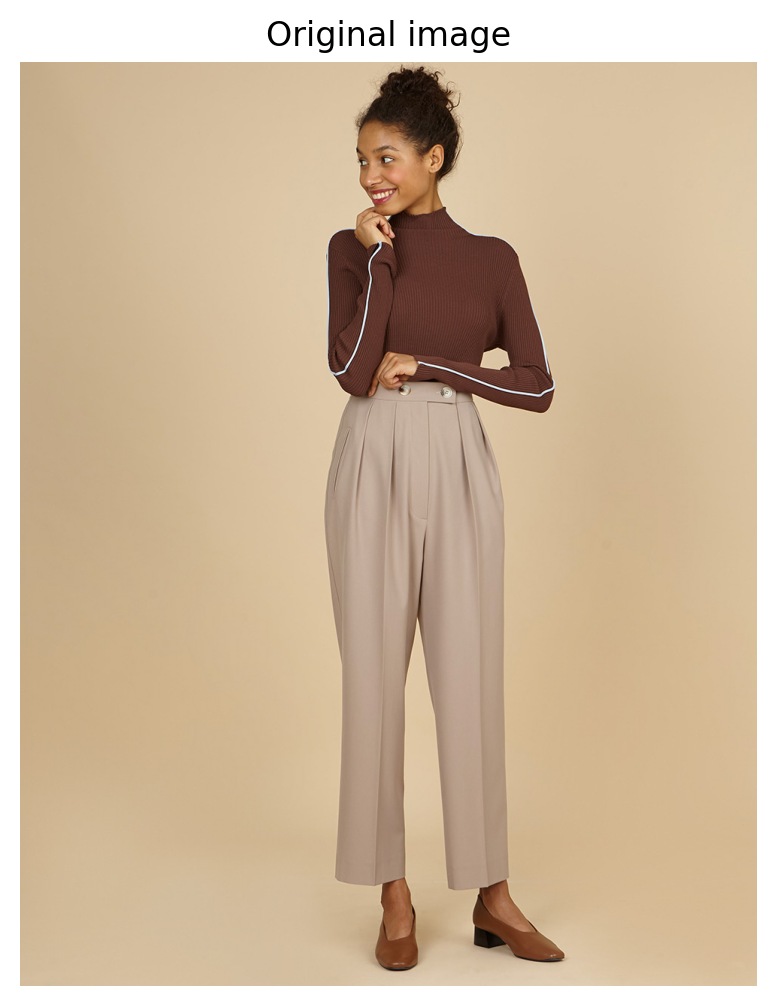

In [25]:
image = './img1660723534.8795.jpg'
# make cropped images
creat_crop_images(image)
plot_one(image, 'Original image')

In [43]:
BODY_CROPS_NAME = ['head', 'hips', 'body', 'body_and_hips', 'right_foot', 'left_foot']

1/1 [==============================] - 0s 47ms/step


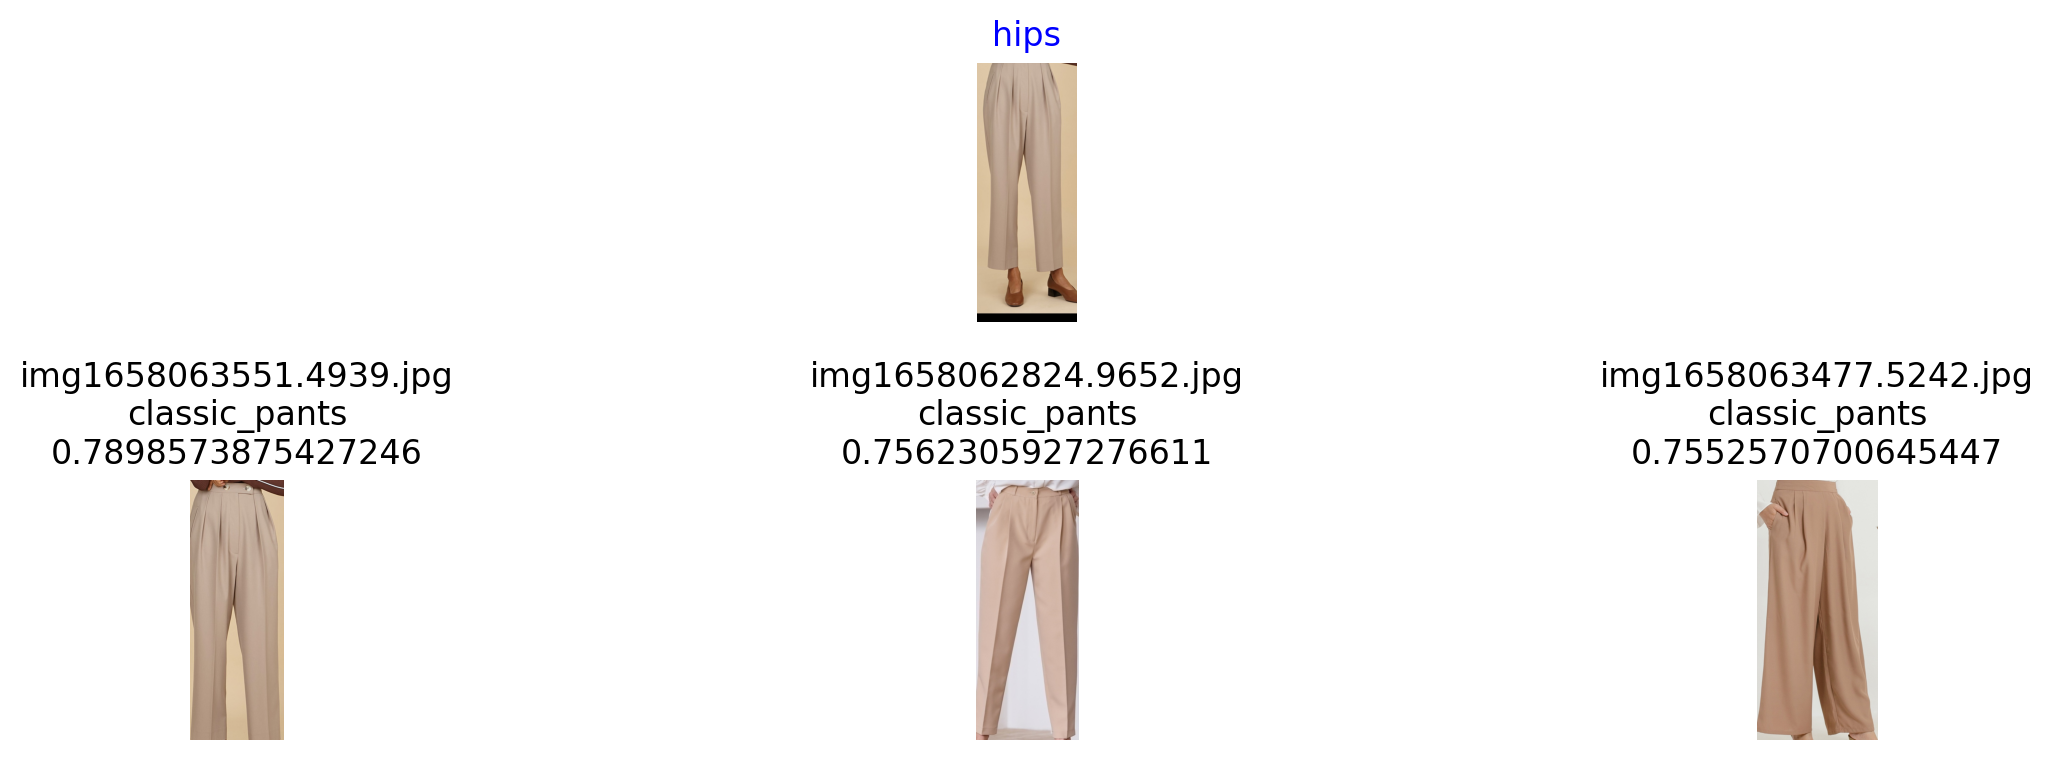

In [44]:
plot_part('hips')

1/1 [==============================] - 0s 44ms/step


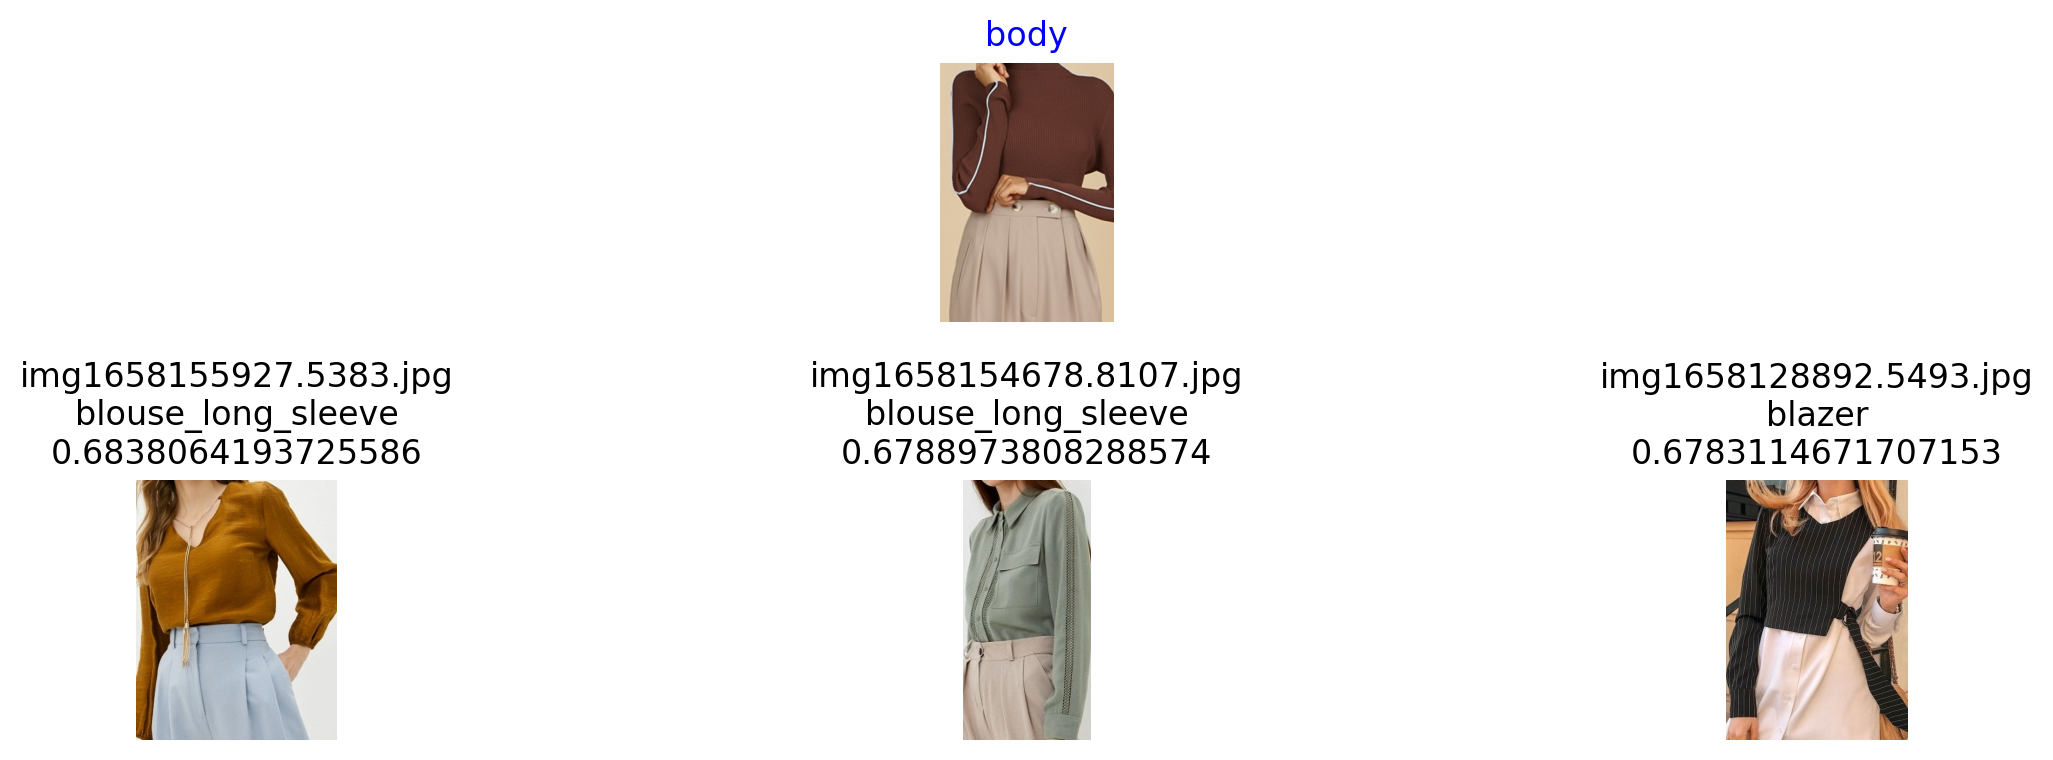

In [45]:
plot_part('body')

1/1 [==============================] - 0s 46ms/step


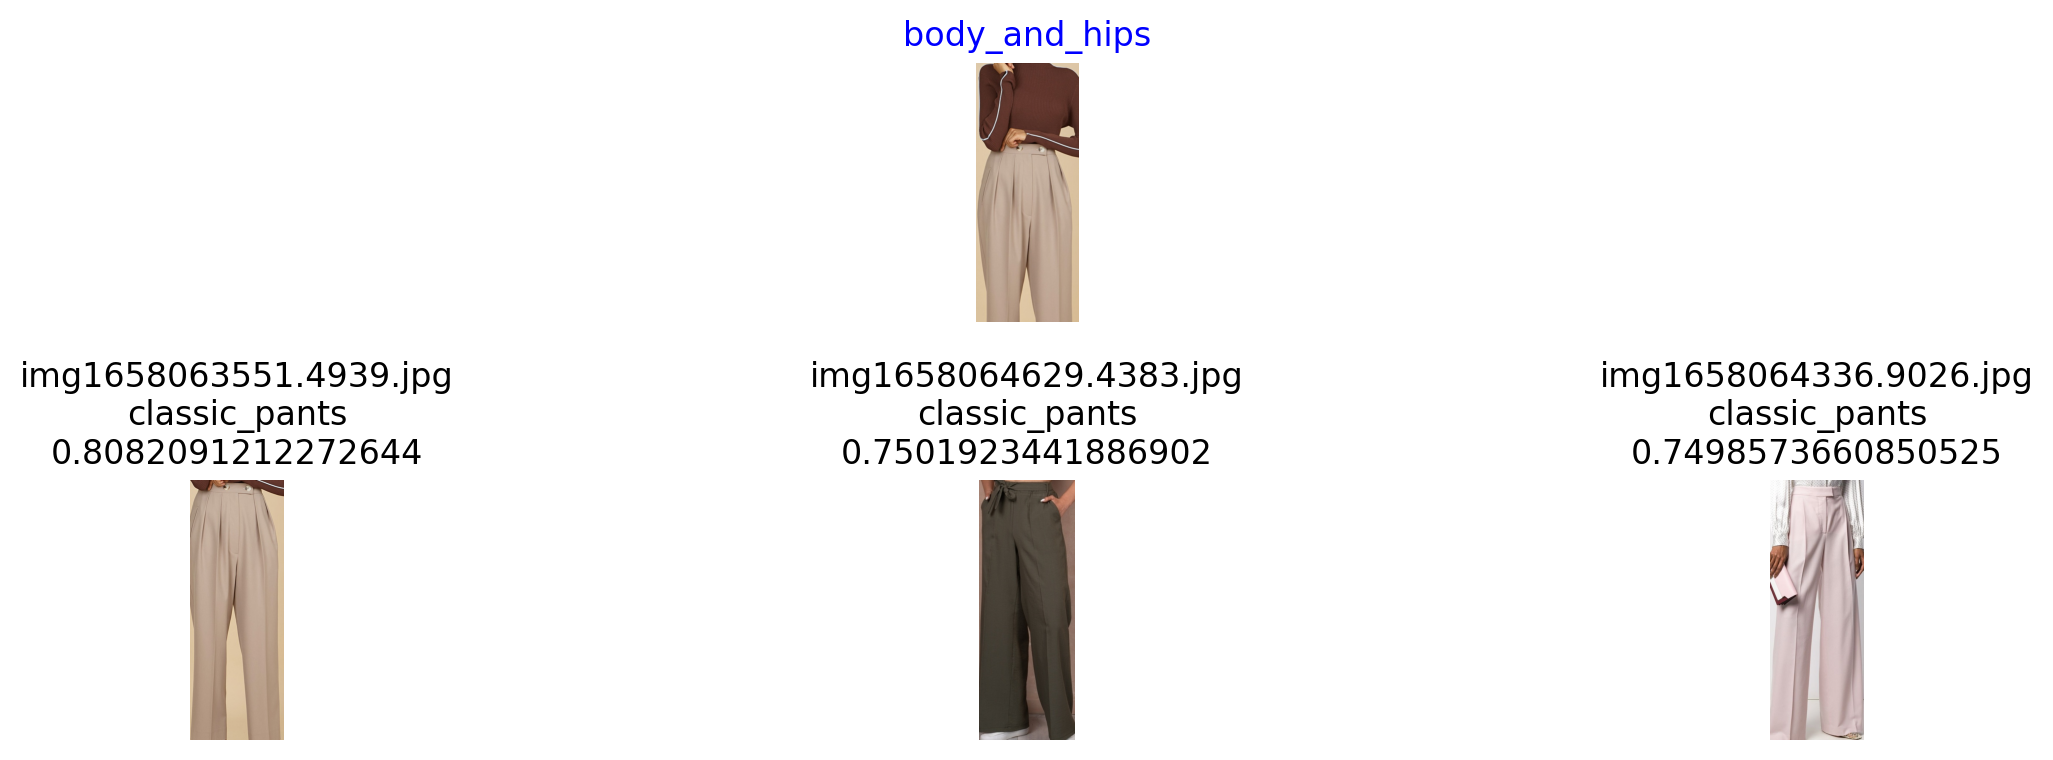

In [46]:
plot_part('body_and_hips')

1/1 [==============================] - 0s 39ms/step


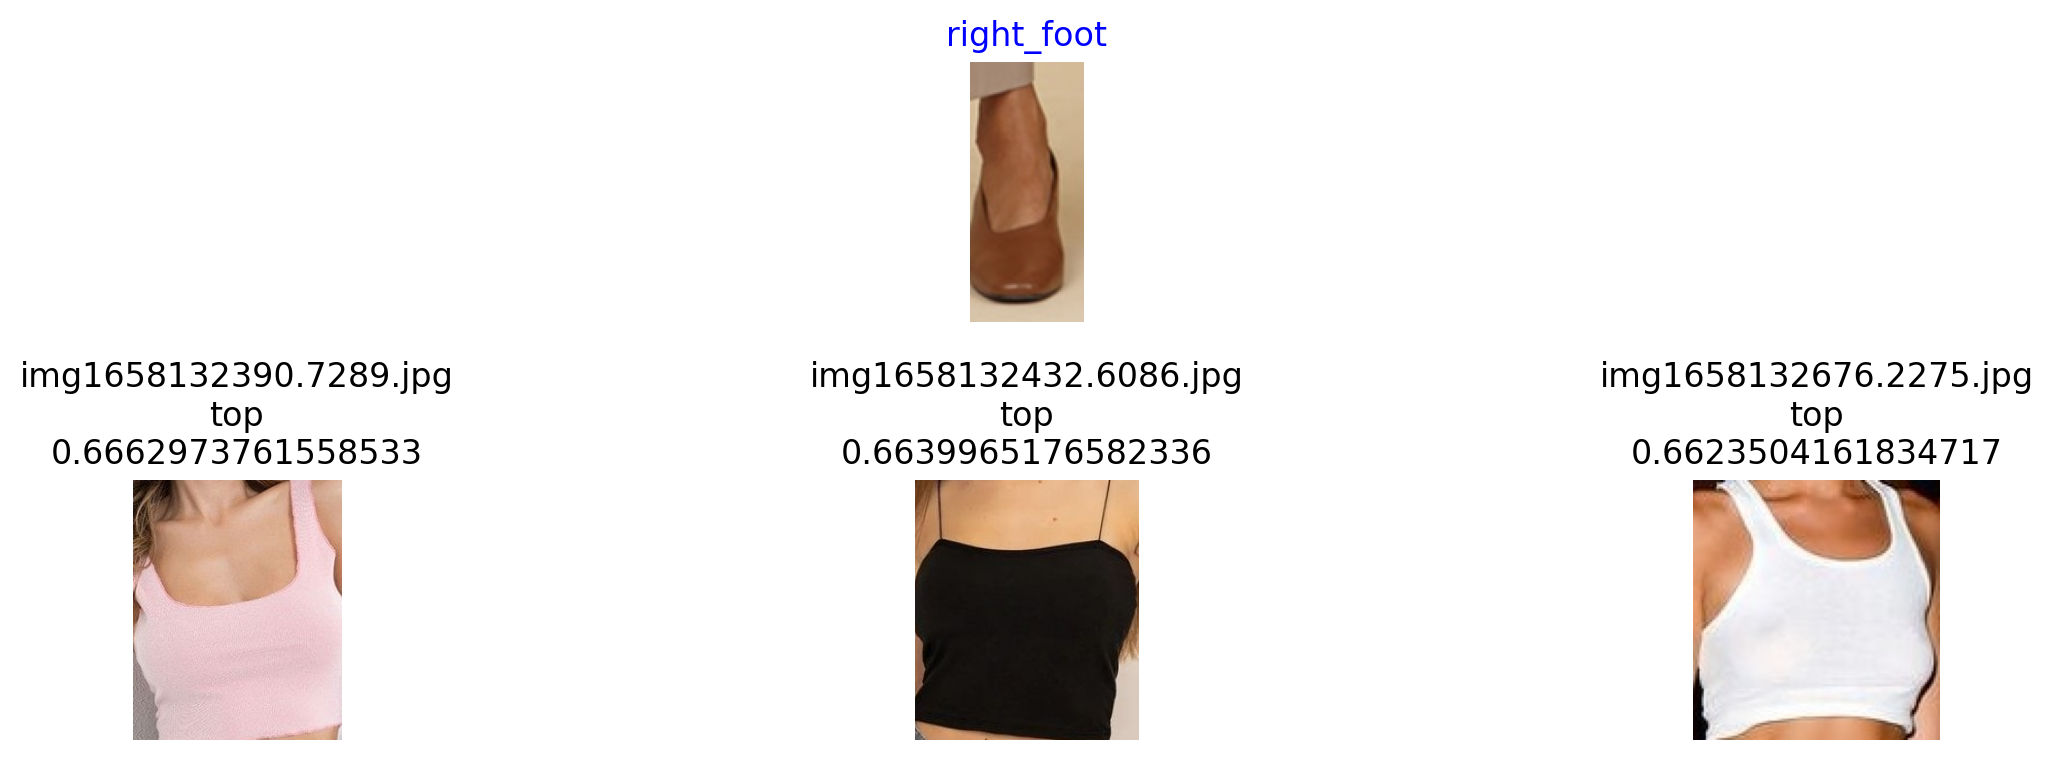

In [47]:
plot_part('right_foot')

1/1 [==============================] - 0s 38ms/step


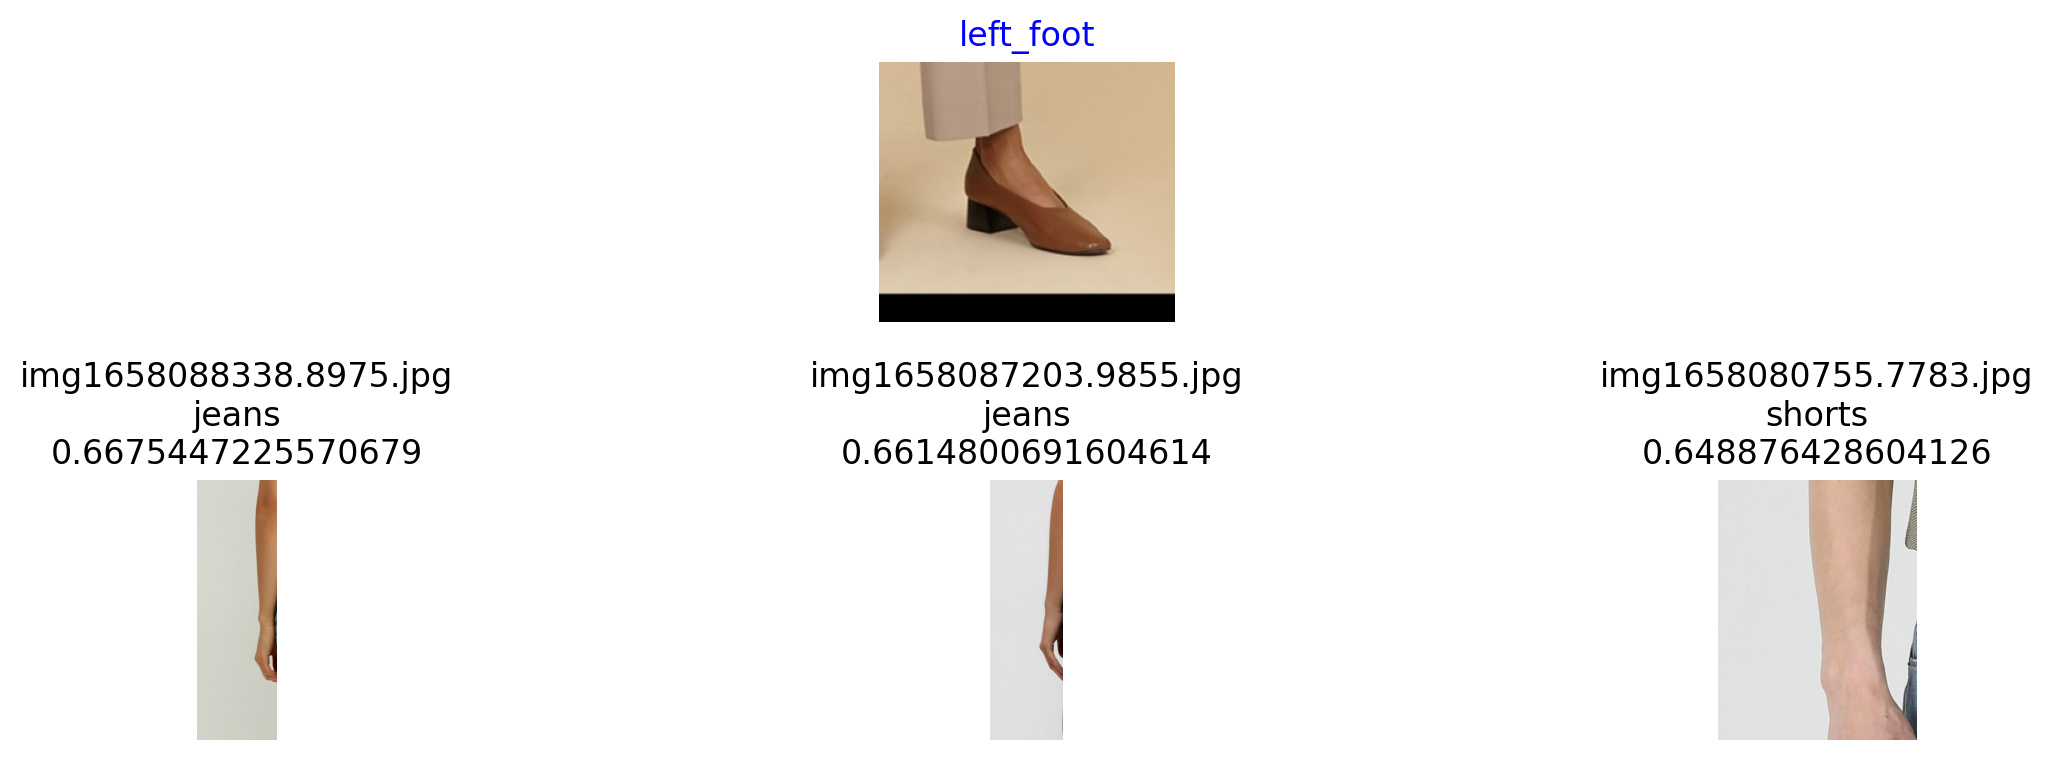

In [48]:
plot_part('left_foot')

### Accuracy

In [27]:
acc_total, acc_dict = accuracy(test_path)

1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 34ms/step


In [28]:
print(f'Точность предсказания класса изображения по всему датасету {acc_total}')

Точность предсказания класса изображения по всему датасету 0.8123011664899258


Точность предсказания по классам

In [29]:
df = pd.DataFrame({**acc_dict}, index=[0]).T
df.columns = ['accuracy']
df.sort_values(by='accuracy', ascending=False)

accuracy
classic_pants        1.000000
shirt_short_sleeve   0.945946
blouse_long_sleeve   0.929936
jeans                0.919192
shirt_polo           0.900000
shorts               0.844037
t_shirt              0.809524
blazer               0.718750
top                  0.653061
shirt_long_sleeve    0.612245
skirt                0.560000
blouse_short_sleeve  0.367347

### Top k images

Изображение из тестового датасета

In [35]:
image_1 = './dataset_v1/train/classic_pants/img1658062808.1126.jpg'

1/1 [==============================] - 0s 48ms/step


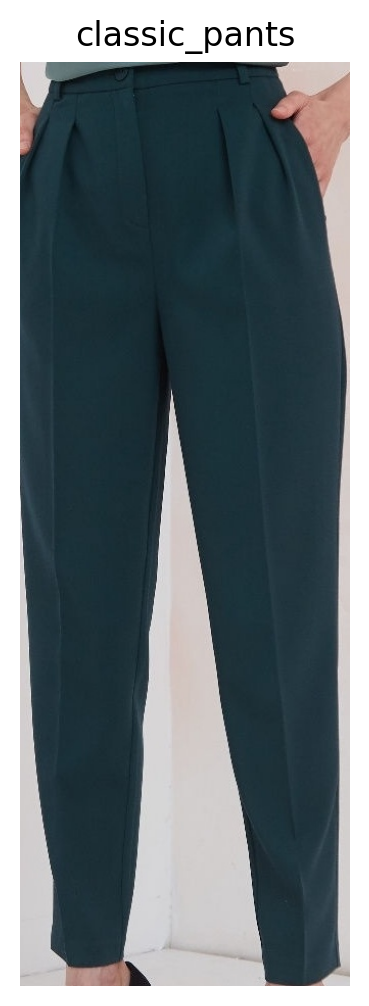

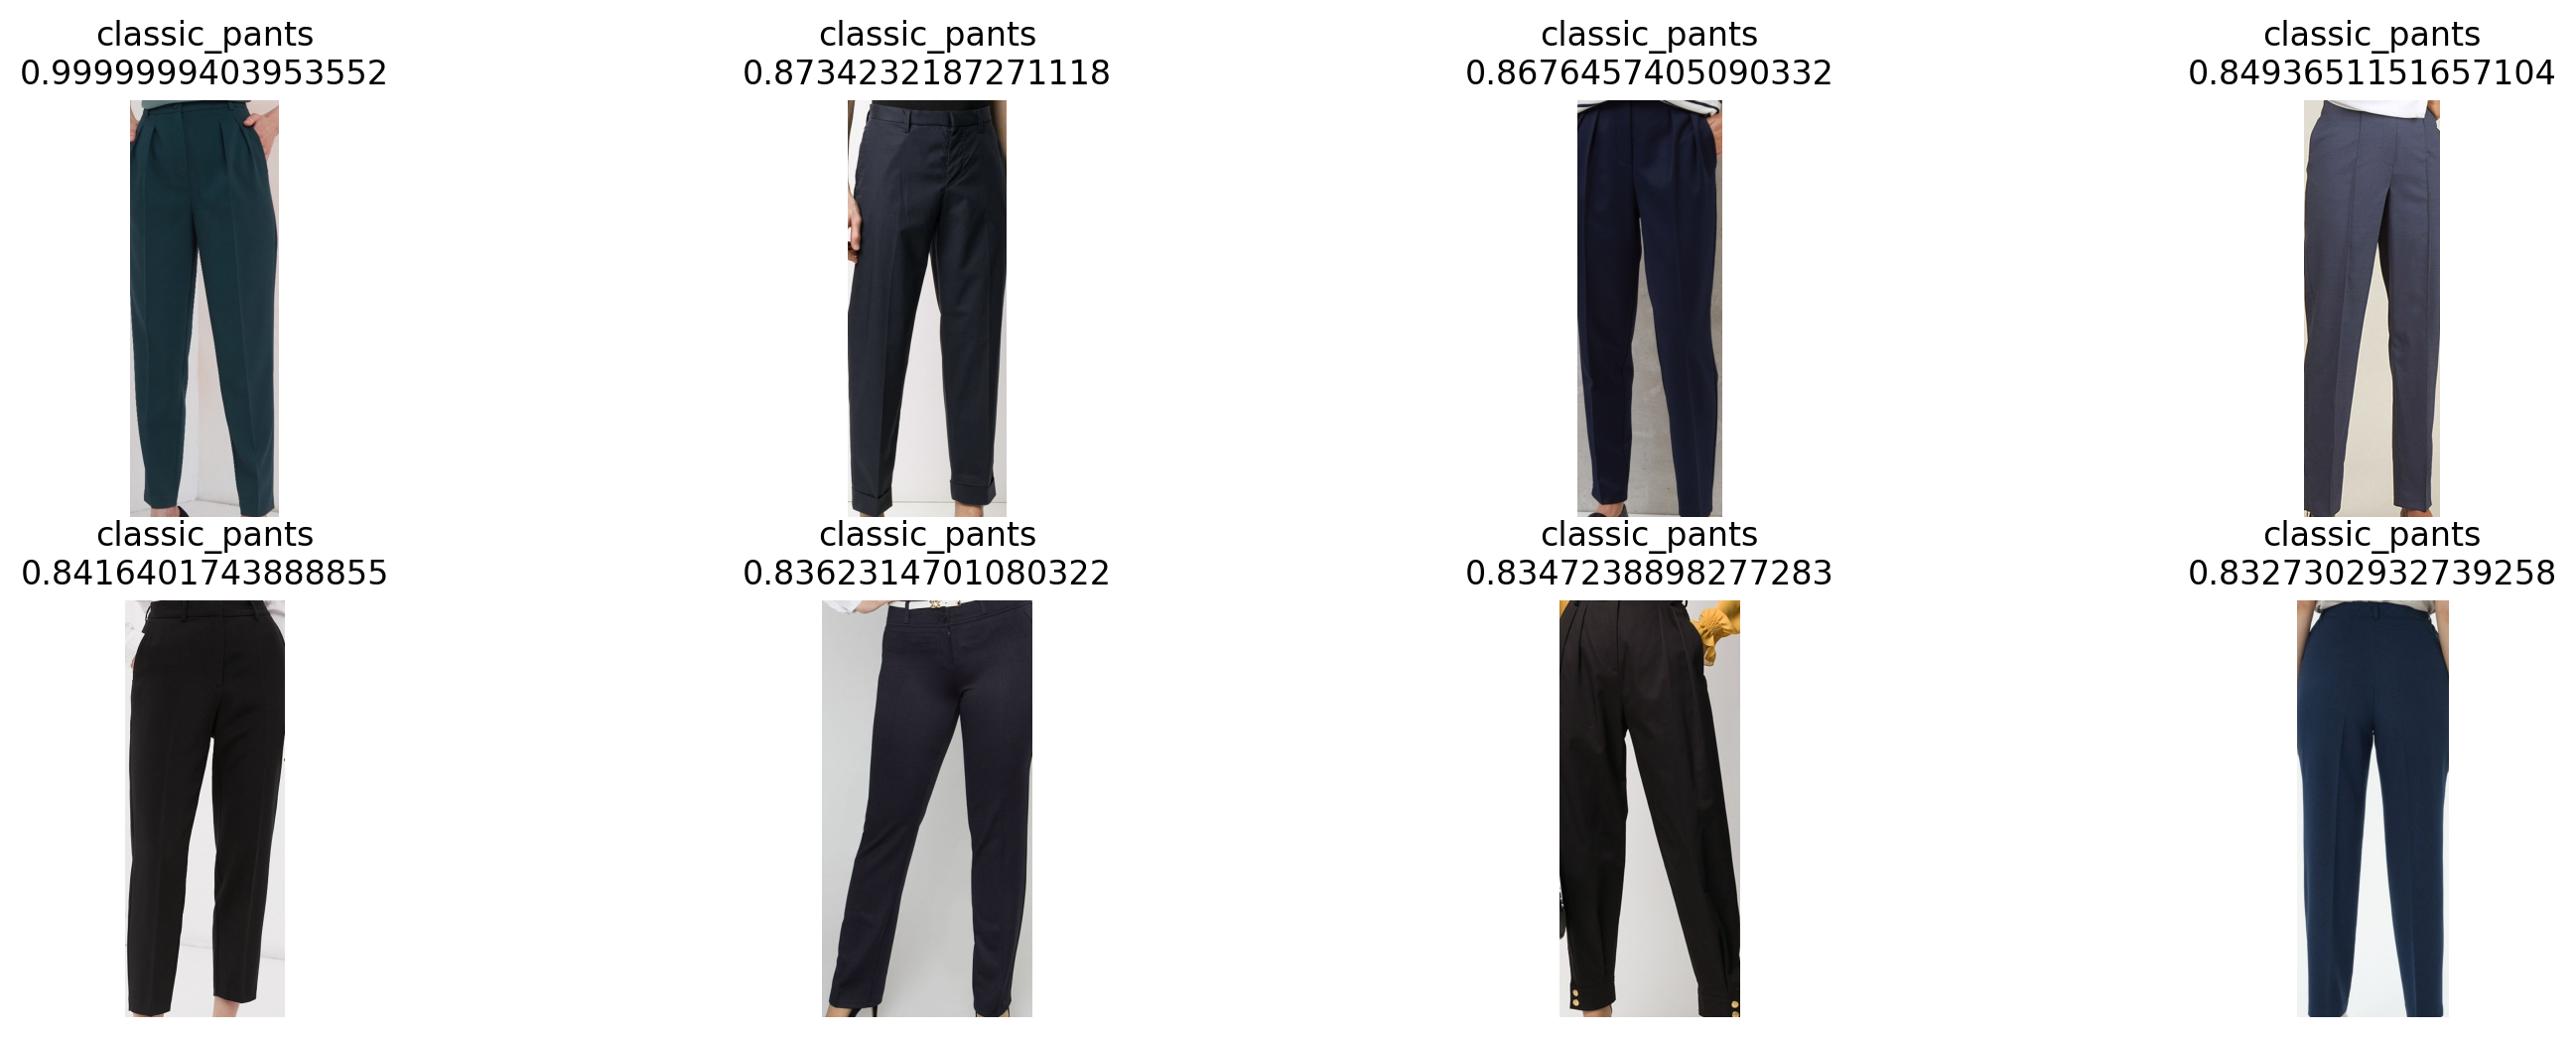

In [36]:
plot_one(image_1)
image_top_k(image_1)

Изображение не из тестового датасета

1/1 [==============================] - 0s 39ms/step


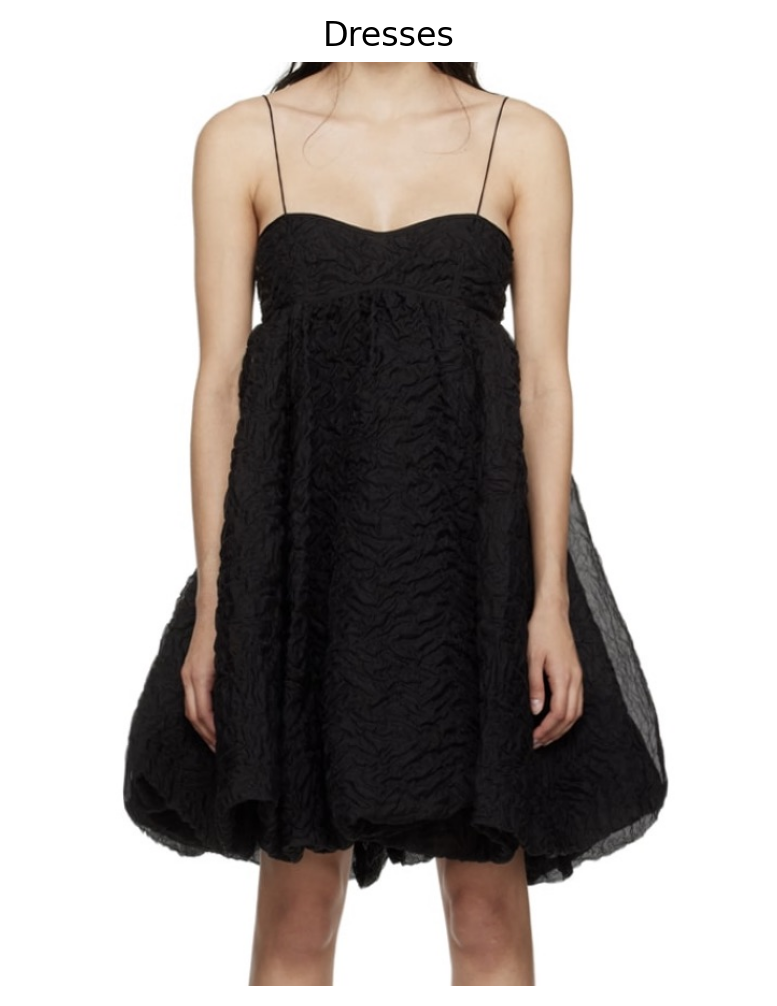

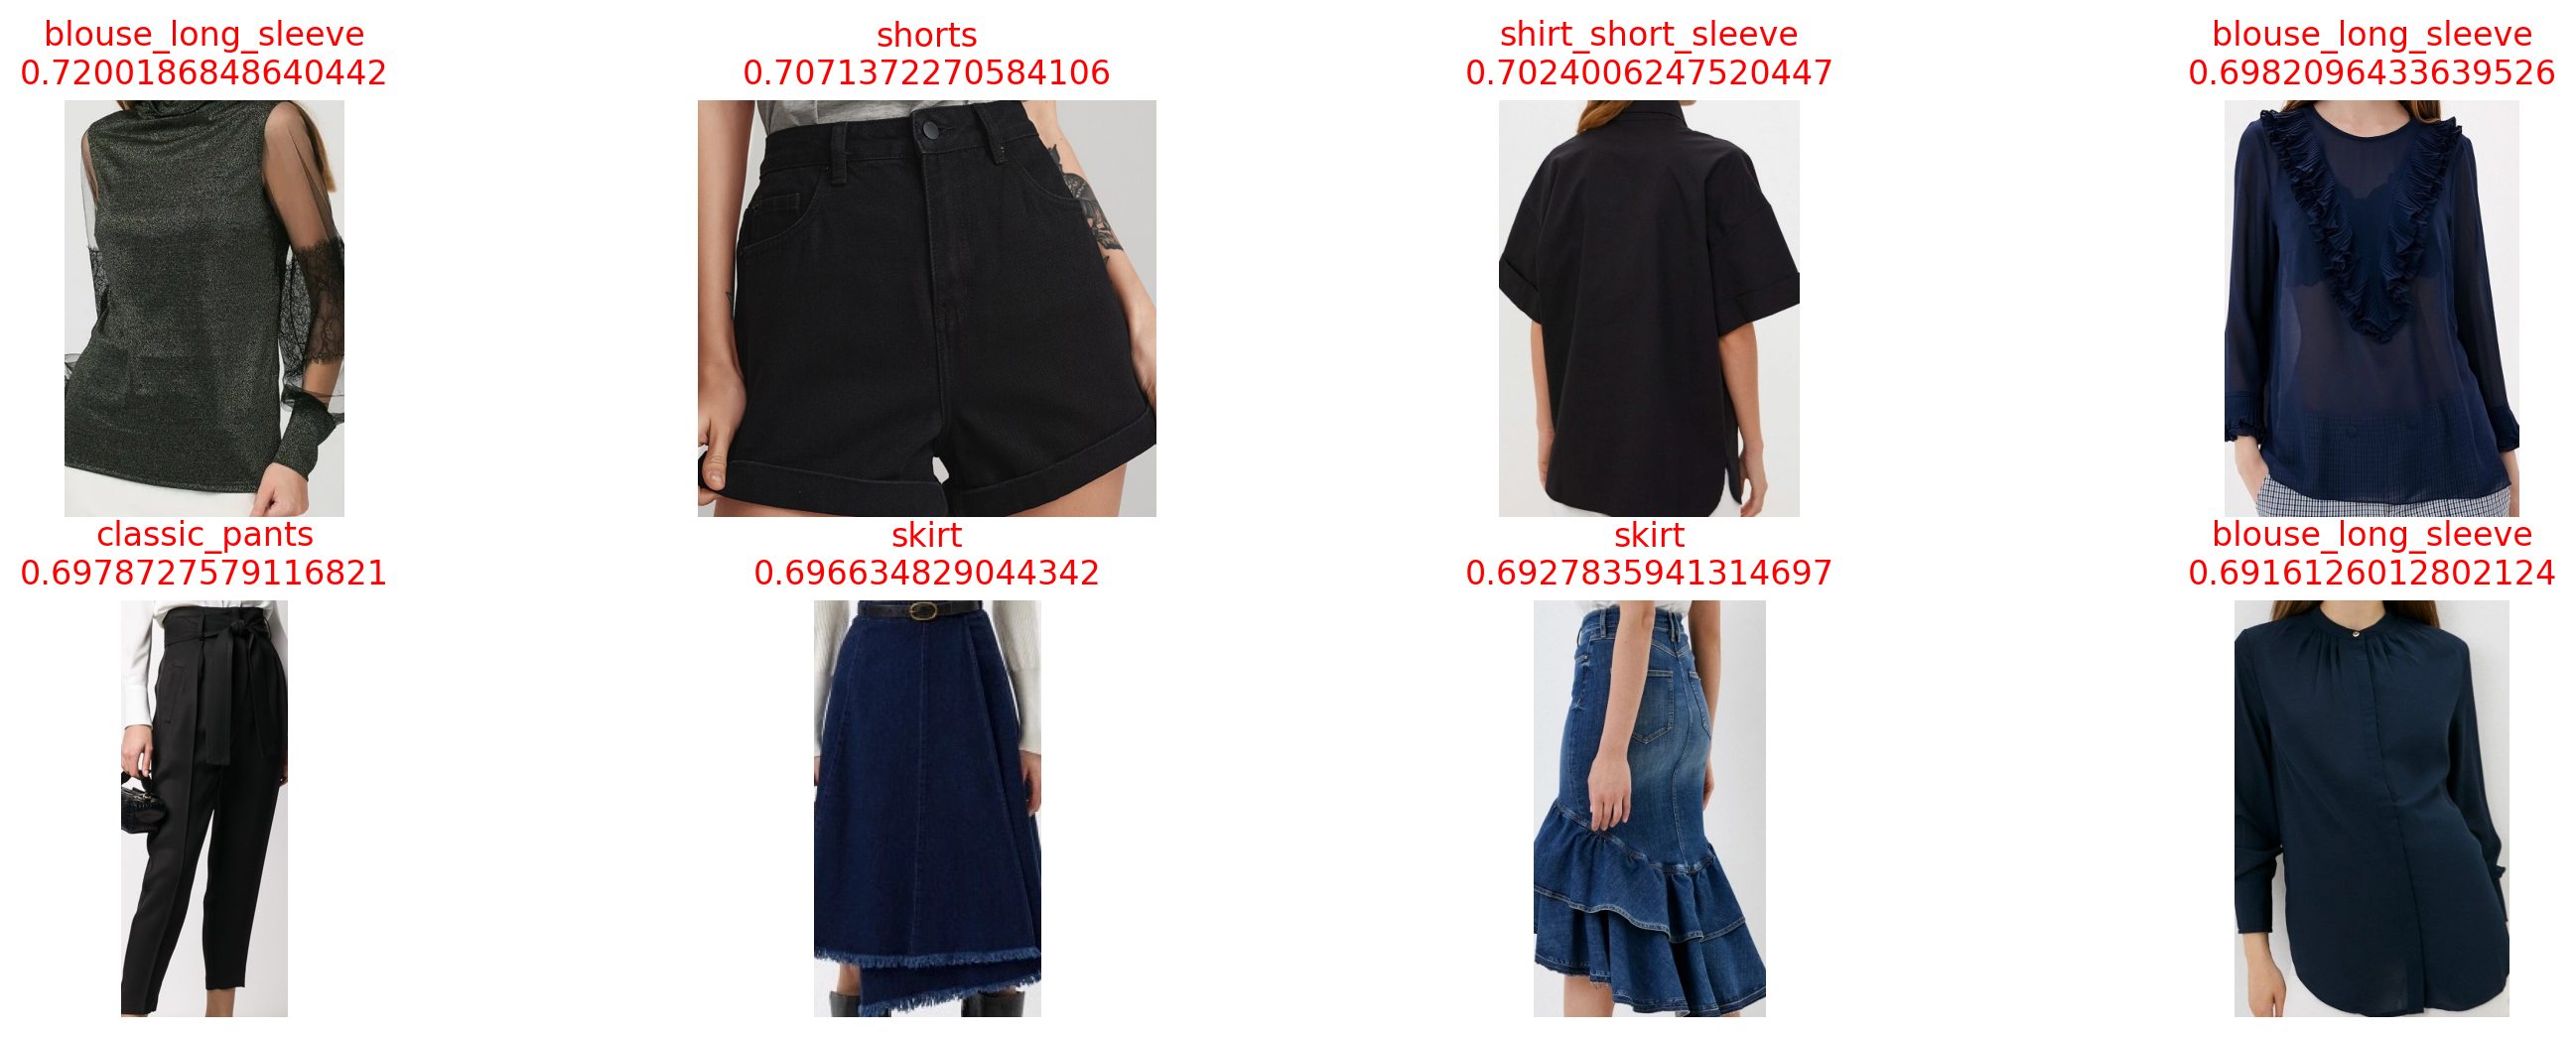

In [32]:
image_2 = './image_2.jpg'
class_name = 'Dresses'

plot_one(image_2, class_name)
image_top_k(image_2, class_name)